## Desafío 3, One hit wonders.

#### Grupo 1

Marcelo Beguisristain beguiris@yahoo.com.ar

Santiago Caraballo santiagocaraballo@gmail.com

Francisco Cossavella franciscocossavella@gmail.com

Maximiliano Zavala maximilian.zvl@gmail.com


## Objetivo

Consultados por una importante discográfica, necesitamos consturir un modelo que le permita a la empresa determinar qué artistas firmar.
Para hacerlo, quieren poder predecir si esos artistas tienen canciones que puedan convertirse en hits o no.
Para responder a esta pregunta, nos proponemos construir un modelo a partir de datos de Spotify que ya están clasificados como hits o misses.

### Importación de librerías:

In [105]:
import pandas as pd
import numpy as np

# modelos y métricas
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, make_scorer, classification_report, auc, precision_recall_curve 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# gráficos
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import pearsonr

# seteo de estilo
plt.rcParams['savefig.bbox'] = "tight"
style.use('dark_background') or plt.style.use('dark_background')

# advertencias
import warnings
warnings.filterwarnings("ignore")

In [106]:
data = pd.read_csv('dataset-of-10s.csv')
data.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1


In [107]:
print(f'Tenemos {data.shape[1]} features y {data.shape[0]} observaciones')

Tenemos 19 features y 6398 observaciones


In [108]:
data.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target'],
      dtype='object')

## Características de los datos

Spotify recolecta mucha información de la música contenida en su plataforma y, en la api de Spotify podemos ver que nuestros features representan:

track: nombre de la pieza.

artist: nombre del artista.

uri: código identificador de Spotify para esa pieza.

danceability: describe qué tanto se puede bailar la pieza musical y se basa en una combinación de elementos musicales como el tempo, la estabilidad rítmica y las regularidades. Un valor de 0 es lo menos bailable y un valor de 1 es lo más bailable. Gilda es muy bailable, Stockhausen no tanto.

energía: una medida de intensidad y actividad, describe música que suele ser fuerte, rápida y ruidosa. Un valor de cero tiene baja energía y uno de 1 tiene alta. Meshuggah tiene alta energía, Arvo Part, no.

key: es la tonalidad de la pieza, va de 1 a 12 siendo C = 1, C# = 2, etc.

loudness: los valores de volumen en db, suelen ir de -60 a 0.

mode: 1 para piezas mayores y 0 para piezas menores.

speachiness: detecta la presencia de palabra hablada. Valores por arriba de 0.66 representan piezas que son casi exclusivamente palabra hablada.

acousticness: una medida de confianza sobre si la pieza es acústica o eléctrica.

instrumentalness: predictor de que la pieza es instrumental.

liveness: detecta la presencia de público en la grabación.

valence: una medida de qué tan positiva o negativa es la pieza, valores cercanos a 1 son muy positivos, valores cercanos a 0 son negativos. es una combinación de tempo, modo, tonalidad y liveness. 

tempo: el tempo que prepondera en la pieza en BPM.

duration_ms: la duración del tema.

time_signature:	una estimación de la métrica que prepondera en la pieza.

chorus_hit:	una medida de aproximadamente cuándo comienza el estribillo de la pieza.

sections: cantidad de secciones que tiene la pieza.

target: variable dicotómica que indica si la pieza fue incluida en el Hot 100 de Billboard en algún momento durante la década comprendida en el dataset.

Además, nos gustaría tener datos del género que más se identifica con el artista así que vamos a incorporar otro dataset de donde obtener esa información.

In [109]:
data_genres = pd.read_csv('data_by_artist_o.csv')
data_genres.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


In [110]:
# mergeamos usando artista como clave
data_new = pd.merge(data, data_genres[['artists', 'genres']], left_on='artist', right_on='artists')
# removemos los corchetes
data_new.genres = data_new.genres.str.strip('[]')
# nos quedamos con el primer género
data_new.genres = data_new.genres.str.split(',').str.get(0)
# miramos la cuenta de valores
data_new.genres.value_counts()

'contemporary country'    545
'dance pop'               410
'pop'                      97
'alternative metal'        94
'atl hip hop'              90
                         ... 
'alabama rap'               1
'bubblegum dance'           1
'folk'                      1
'country rock'              1
'electro house'             1
Name: genres, Length: 317, dtype: int64

In [111]:
data.dtypes

track                object
artist               object
uri                  object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
chorus_hit          float64
sections              int64
target                int64
dtype: object

Todos los tipo de datos son consistentes con la descripción que provee Spotify, vamos a explorar un poco los géneros antes de generar el dataframe con el que vamos a trabajar.

Seleccionamos algunos colores que vamos a usar para los gráficos.

In [112]:
sns.color_palette('rocket')

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [113]:
sns.color_palette('twilight_shifted')

[(0.36002681809096376, 0.20694122817889948, 0.6029284543191687),
 (0.4113541469730457, 0.5368485776500593, 0.7466971285506578),
 (0.7387377170049494, 0.7959766573503101, 0.8214292278043301),
 (0.8398783988412087, 0.7603990719977968, 0.7136714781112923),
 (0.7387914002459927, 0.4205367299231533, 0.34913260148542435),
 (0.4981443546207415, 0.13569380302451714, 0.314135190862664)]

In [114]:
sns.color_palette('cubehelix_r')

[(0.7775608374378459, 0.884039252121245, 0.9452007992345051),
 (0.8046168329276406, 0.6365733569301846, 0.8796578402926125),
 (0.7829183382530567, 0.48158303462490826, 0.48672451968362596),
 (0.4106130272672764, 0.4804478054167226, 0.1891154277778484),
 (0.10594361078604106, 0.3809739011595331, 0.27015111282899046),
 (0.10231025194333626, 0.13952898866828914, 0.25601203194091815)]

In [115]:
pal_1 = sns.color_palette('rocket')
print(pal_1.as_hex())

['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']


In [116]:
pal_2 = sns.color_palette('twilight_shifted')
print(pal_2.as_hex())

['#5c359a', '#6989be', '#bccbd1', '#d6c2b6', '#bc6b59', '#7f2350']


In [117]:
pal_3 = sns.color_palette('cubehelix_r')
print(pal_3.as_hex())

['#c6e1f1', '#cda2e0', '#c87b7c', '#697b30', '#1b6145', '#1a2441']


In [118]:
pal = ['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f', '#5c359a', '#6989be', '#bccbd1', '#d6c2b6', '#bc6b59', '#7f2350', '#c6e1f1', '#cda2e0', '#c87b7c', '#697b30', '#1b6145', '#1a2441'] 

In [119]:
data_new.genres.unique()

array(["'canadian contemporary r&b'", "'easy listening'", "'danish pop'",
       "'bass trap'", "'canadian pop'", "'alternative metal'",
       "'atl hip hop'", "'contemporary country'", "'downtempo'",
       "'adult standards'", "'canadian hip hop'", "'detroit hip hop'",
       "'dark trap'", "'banjo'", "'acoustic pop'", "'alternative dance'",
       "'background music'", "'pop'", "'dance pop'", "'social media pop'",
       "'indie folk'", "'emo rap'", "'banda'", "'big band'",
       "'gangster rap'", "'calypso'", "'bebop'", "'art pop'",
       "'boy band'", "'art rock'", "'melodic rap'", "'country rap'",
       "'austindie'", "'hip hop'", "'epicore'", "'emo'",
       "'alternative country'", "'alternative r&b'", "'baroque'",
       "'conscious hip hop'", "'folk-pop'", "'chillwave'", "'big room'",
       "'deathcore'", "'austin americana'",
       "'christian alternative rock'", "'pop r&b'", "'contemporary jazz'",
       "'neo mellow'", "'american contemporary classical'",
       "'de

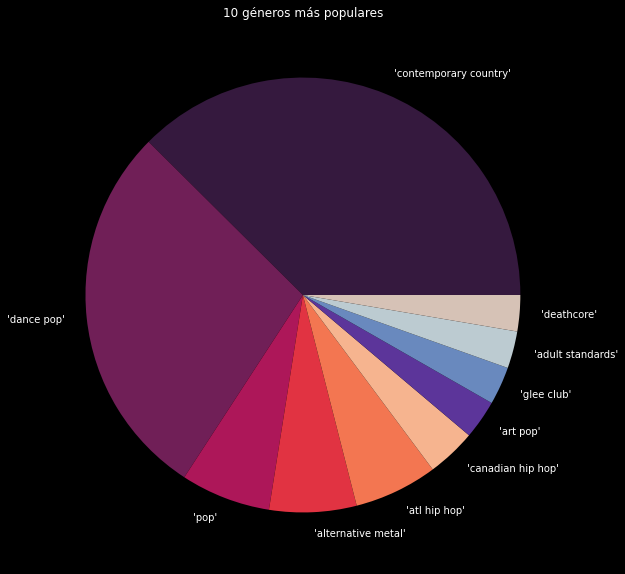

In [120]:
fig = plt.figure(figsize = (10, 10))
ax = fig.subplots()
data_new.genres.value_counts()[:10].plot(ax=ax, kind = "pie", colors=pal)
ax.set_ylabel("")
ax.set_title('10 géneros más populares')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.show()

Primero vemos que tenemos muchísimos géneros y que evidentemente nuestros géneros están bastante desbalanceados.

Además, los que entran en el top 10 son géneros súper específicos que tal vez no sean representativos, vamos a mirar con más detalle las palabras que describen cada género para ver si hay palabras en común, indicando géneros que se solapan.

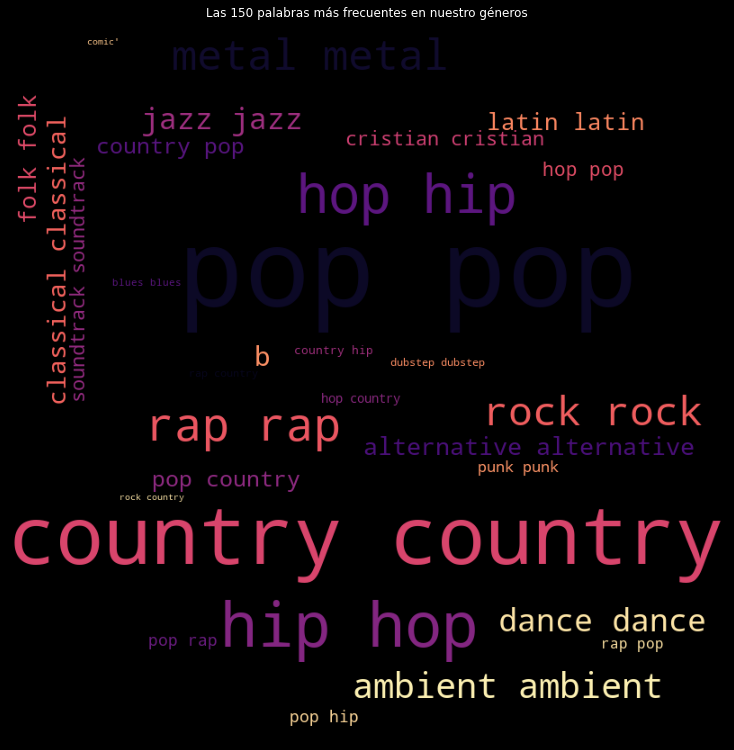

In [254]:
max_words = 150
wordcloud = WordCloud(width = 800, height = 800, max_words = max_words, colormap="magma",
                min_font_size = 10).generate(" ".join(data_new.genres))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"Las {max_words} palabras más frecuentes en nuestro géneros")
plt.show();

Acá se vuelve a ver que hay géneros que están sobrerepresentados, hay géneros redundantes y también vemos que muchos comparten palabras como pop, country, hip-hop.

Vamos a definir un conjunto de géneros menor que representen éstos y mapear los géneros viejos a los nuevos, para esto necesitamos tener bastante conocimiento de dominio porque hay muchos géneros cuya cateogoría superordinada no es particularmente clara.

In [122]:
genres = data_new.genres

La primera categoría, y la más problemática, es 'dance pop'. Es problemática porque ambas palabras de por sí podrían representar un género.

Vamos a ver qué artistas reciben esta etiqueta y decidir cuál de las dos etiquetas es más representativa.

In [123]:
data_new.loc[data_new.genres.str.contains('dance pop') == True].artist.unique()

array(['P!nk', 'Flo Rida', 'Taylor Swift', 'Niall Horan', 'Nicki Minaj',
       'Bruno Mars', 'Echosmith', 'Demi Lovato', 'OneRepublic', 'Maxwell',
       'Enrique Iglesias', 'Katy Perry', 'Daya', 'Alexandra Stan',
       'Jason Derulo', 'OMI', 'Felix Jaehn', 'Fifth Harmony',
       'Selena Gomez', 'Julia Michaels', 'Cher Lloyd', 'Cashmere Cat',
       'Lady Gaga', 'Rita Ora', 'Kelly Clarkson', 'Trey Songz',
       'The Chainsmokers', 'Mabel', 'LMFAO', 'Meghan Trainor',
       'Miley Cyrus', 'Monica', 'Selena Gomez & The Scene', 'Karmin',
       'Whitney Houston', 'Halsey', 'Ellie Goulding', 'Calvin Harris',
       'Camila Cabello', 'Jaheim', 'Andy Grammer', 'Zara Larsson',
       'Duke Dumont', 'Train', 'Dua Lipa', 'Cam', 'Adam Lambert',
       'Robin Thicke', 'Hot Chelle Rae', 'Justin Timberlake',
       'Nico & Vinz', 'Miguel', 'Kiiara', 'Britney Spears', 'Taio Cruz',
       'Jess Glynne', 'Christina Perri', 'Chris Brown', 'Mr. Probz',
       'Fergie', 'Zendaya', 'Christina Grimmie'

Acá vemos claramente que los artistas de pop están sobrerepresentados, hay algunos artistas que podrían ser considerados como de dance como Calvin Harris o DNCE pero es más seguro asignarlos al género pop y construir un género de dance que sea más específico.

In [124]:
genres.loc[genres.str.contains('pop') == True] = 'pop'
genres.value_counts()

pop                       773
'contemporary country'    545
'alternative metal'        94
'atl hip hop'              90
'canadian hip hop'         53
                         ... 
'meme rap'                  1
'acid trance'               1
'latin christian'           1
'indie garage rock'         1
'modern country rock'       1
Name: genres, Length: 271, dtype: int64

También vimos que Glee Club es un género popular, las canciones de Glee son versiones pop de temas conocidos de distintas épocas:

In [125]:
data_new.loc[data_new.genres.str.contains('glee club') == True][['artist', 'track']]

,artist,track
875,Glee Cast,P.Y.T. (Pretty Young Thing)
876,Glee Cast,Animal
877,Glee Cast,U Can't Touch This
878,Glee Cast,Need You Now
879,Glee Cast,You Can't Stop The Beat
880,Glee Cast,Listen
881,Glee Cast,Tell Me Something Good
882,Glee Cast,Another One Bites The Dust
883,Glee Cast,Billionaire
884,Glee Cast,Empire State Of Mind


Es claro que la música de Glee es pop, cambiamos el género.

In [126]:
genres.loc[genres.str.contains('glee club') == True] = 'pop'
genres.value_counts()

pop                       814
'contemporary country'    545
'alternative metal'        94
'atl hip hop'              90
'canadian hip hop'         53
                         ... 
'meme rap'                  1
'acid trance'               1
'latin christian'           1
'indie garage rock'         1
'modern country rock'       1
Name: genres, Length: 270, dtype: int64

Lo mismo para las boy bands.

In [127]:
genres.loc[genres.str.contains('boy band') == True] = 'pop'
genres.value_counts()

pop                       843
'contemporary country'    545
'alternative metal'        94
'atl hip hop'              90
'canadian hip hop'         53
                         ... 
'meme rap'                  1
'acid trance'               1
'latin christian'           1
'indie garage rock'         1
'modern country rock'       1
Name: genres, Length: 269, dtype: int64

Seguimos con otros géneros más evidentes:

In [128]:
genres.loc[genres.str.contains('dance') == True] = 'dance'
genres.value_counts()

pop                       843
'contemporary country'    545
'alternative metal'        94
'atl hip hop'              90
dance                      64
                         ... 
'modern country rock'       1
'meme rap'                  1
'freak folk'                1
'christian punk'            1
'electro house'             1
Name: genres, Length: 265, dtype: int64

In [129]:
genres.loc[genres.str.contains('country') == True] = 'country'
genres.value_counts()

pop                    843
country                607
'alternative metal'     94
'atl hip hop'           90
dance                   64
                      ... 
'bluegrass'              1
'dark disco'             1
'latin talent show'      1
'australian indie'       1
'folk'                   1
Name: genres, Length: 256, dtype: int64

In [130]:
genres.loc[genres.str.contains('hip hop') == True] = 'hip hop'
genres.value_counts()

pop                    843
country                607
hip hop                280
'alternative metal'     94
dance                   64
                      ... 
'bluegrass'              1
'dark disco'             1
'latin talent show'      1
'australian indie'       1
'folk'                   1
Name: genres, Length: 240, dtype: int64

In [131]:
genres.loc[genres.str.contains('rock') == True] = 'rock'
genres.value_counts()

pop                    843
country                607
hip hop                280
rock                   158
'alternative metal'     94
                      ... 
'deep talent show'       1
'jam band'               1
'athens indie'           1
'canadian ccm'           1
'electro house'          1
Name: genres, Length: 219, dtype: int64

In [132]:
genres.loc[genres.str.contains('metal') == True] = 'metal'
genres.value_counts()

pop               843
country           607
hip hop           280
rock              158
metal             145
                 ... 
'athens indie'      1
'canadian ccm'      1
'bluegrass'         1
'dark disco'        1
'meme rap'          1
Name: genres, Length: 204, dtype: int64

El deathcore es un subgénero de metal, lo asignamos:

In [133]:
genres.loc[genres.str.contains('deathcore') == True] = 'metal'
genres.value_counts()

pop               843
country           607
hip hop           280
metal             184
rock              158
                 ... 
'athens indie'      1
'canadian ccm'      1
'bluegrass'         1
'dark disco'        1
'meme rap'          1
Name: genres, Length: 203, dtype: int64

In [134]:
genres.loc[genres.str.contains('rap') == True] = 'rap'
genres.value_counts()

pop                843
country            607
hip hop            280
rap                195
metal              184
                  ... 
'funk carioca'       1
'jazz funk'          1
'disco'              1
'drum and bass'      1
'electro house'      1
Name: genres, Length: 182, dtype: int64

Seleccionamos algunos géneros asociados al dance:

In [135]:
genres.loc[genres.str.contains('disco') == True] = 'dance'
genres.value_counts()

pop                      843
country                  607
hip hop                  280
rap                      195
metal                    184
                        ... 
'bluegrass'                1
'latin talent show'        1
'australian indie'         1
'classical saxophone'      1
'deep talent show'         1
Name: genres, Length: 179, dtype: int64

In [136]:
genres.loc[genres.str.contains('house') == True] = 'dance'
genres.value_counts()

pop               843
country           607
hip hop           280
rap               195
metal             184
                 ... 
'mariachi'          1
'grave wave'        1
'acid trance'       1
'bass music'        1
'chicago punk'      1
Name: genres, Length: 175, dtype: int64

In [137]:
genres.loc[genres.str.contains('big room') == True] = 'dance'
genres.value_counts()

pop                   843
country               607
hip hop               280
rap                   195
metal                 184
                     ... 
'chicago punk'          1
'australian psych'      1
'bass music'            1
'folk punk'             1
'latin christian'       1
Name: genres, Length: 174, dtype: int64

In [138]:
genres.loc[genres.str.contains('r&b') == True] = 'r&b'
genres.value_counts()

pop               843
country           607
hip hop           280
rap               195
metal             184
                 ... 
'art punk'          1
'mariachi'          1
'acid trance'       1
'chicago punk'      1
'grave wave'        1
Name: genres, Length: 173, dtype: int64

In [139]:
genres.loc[genres.str.contains('punk') == True] = 'punk'
genres.value_counts()

pop                  843
country              607
hip hop              280
rap                  195
metal                184
                    ... 
'double drumming'      1
'mariachi'             1
'idol'                 1
'bass music'           1
'ballroom'             1
Name: genres, Length: 166, dtype: int64

In [140]:
genres.loc[genres.str.contains('grunge') == True] = 'punk'
genres.value_counts()

pop                  843
country              607
hip hop              280
rap                  195
metal                184
                    ... 
'double drumming'      1
'mariachi'             1
'idol'                 1
'bass music'           1
'ballroom'             1
Name: genres, Length: 165, dtype: int64

Lo mismo con el folk:

In [141]:
genres.loc[genres.str.contains('folk') == True] = 'folk'
genres.value_counts()

pop                  843
country              607
hip hop              280
rap                  195
metal                184
                    ... 
'double drumming'      1
'mariachi'             1
'idol'                 1
'bass music'           1
'ballroom'             1
Name: genres, Length: 159, dtype: int64

In [142]:
genres.loc[genres.str.contains('banjo') == True] = 'folk'
genres.value_counts()[:10]

pop                  843
country              607
hip hop              280
rap                  195
metal                184
rock                 158
dance                111
folk                  49
r&b                   48
'adult standards'     40
Name: genres, dtype: int64

In [143]:
genres.loc[genres.str.contains('singer-songwriter') == True] = 'folk'
genres.value_counts()[:10]

pop                  843
country              607
hip hop              280
rap                  195
metal                184
rock                 158
dance                111
folk                  50
r&b                   48
'adult standards'     40
Name: genres, dtype: int64

In [144]:
genres.loc[genres.str.contains('bluegrass') == True] = 'folk'
genres.value_counts()[:10]

pop                  843
country              607
hip hop              280
rap                  195
metal                184
rock                 158
dance                111
folk                  51
r&b                   48
'adult standards'     40
Name: genres, dtype: int64

Lo mismo que el jazz:

In [145]:
genres.loc[genres.str.contains('jazz') == True] = 'jazz'
genres.value_counts()[:10]

pop                  843
country              607
hip hop              280
rap                  195
metal                184
rock                 158
dance                111
folk                  51
r&b                   48
'adult standards'     40
Name: genres, dtype: int64

In [146]:
genres.loc[genres.str.contains('bop') == True] = 'jazz'
genres.value_counts()[:10]

pop        843
country    607
hip hop    280
rap        195
metal      184
rock       158
dance      111
jazz        69
folk        51
r&b         48
Name: genres, dtype: int64

In [147]:
genres.loc[genres.str.contains('bebop') == True] = 'jazz'
genres.value_counts()[:15]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                        69
folk                        51
r&b                         48
'adult standards'           40
'anthem worship'            32
punk                        30
'compositional ambient'     28
                            28
Name: genres, dtype: int64

In [148]:
genres.loc[genres.str.contains('adult standards') == True] = 'jazz'
genres.value_counts()[:15]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       109
folk                        51
r&b                         48
'anthem worship'            32
punk                        30
'compositional ambient'     28
                            28
'baroque'                   26
Name: genres, dtype: int64

In [149]:
genres.loc[genres.str.contains('baroque') == True] = 'classical'
genres.value_counts()[:15]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       109
folk                        51
r&b                         48
'anthem worship'            32
punk                        30
'compositional ambient'     28
                            28
classical                   26
Name: genres, dtype: int64

In [150]:
genres.loc[genres.str.contains('classical') == True] = 'classical'
genres.value_counts()[:15]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       109
classical                   53
folk                        51
r&b                         48
'anthem worship'            32
punk                        30
'compositional ambient'     28
                            28
Name: genres, dtype: int64

In [151]:
genres.loc[genres.str.contains('chill') == True] = 'ambient'
genres.value_counts()[:15]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       109
classical                   53
folk                        51
r&b                         48
ambient                     41
'anthem worship'            32
punk                        30
'compositional ambient'     28
Name: genres, dtype: int64

In [152]:
genres.loc[genres.str.contains('alt') == True] = 'alternative'
genres.value_counts()[:15]

pop                 843
country             607
hip hop             280
rap                 195
metal               184
rock                158
dance               111
jazz                109
classical            53
folk                 51
r&b                  48
ambient              41
'anthem worship'     32
alternative          31
punk                 30
Name: genres, dtype: int64

In [153]:
genres.loc[genres.str.contains('alternative') == True] = 'alternative'
genres.value_counts()[:15]

pop                 843
country             607
hip hop             280
rap                 195
metal               184
rock                158
dance               111
jazz                109
classical            53
folk                 51
r&b                  48
ambient              41
'anthem worship'     32
alternative          31
punk                 30
Name: genres, dtype: int64

In [154]:
genres.loc[genres.str.contains('indie') == True] = 'alternative'
genres.value_counts()[:15]

pop                 843
country             607
hip hop             280
rap                 195
metal               184
rock                158
dance               111
jazz                109
alternative          58
classical            53
folk                 51
r&b                  48
ambient              41
'anthem worship'     32
punk                 30
Name: genres, dtype: int64

In [155]:
genres.loc[genres.str.contains('soundtrack') == True] = 'soundtrack'
genres.value_counts()[:15]

pop                 843
country             607
hip hop             280
rap                 195
metal               184
rock                158
dance               111
jazz                109
alternative          58
classical            53
folk                 51
r&b                  48
ambient              41
'anthem worship'     32
punk                 30
Name: genres, dtype: int64

In [156]:
genres.loc[genres.str.contains('epicore') == True] = 'soundtrack'
genres.value_counts()[:15]

pop                 843
country             607
hip hop             280
rap                 195
metal               184
rock                158
dance               111
jazz                109
alternative          58
classical            53
folk                 51
r&b                  48
soundtrack           44
ambient              41
'anthem worship'     32
Name: genres, dtype: int64

In [157]:
genres.loc[genres.str.contains('anthem worship') == True] = 'cristian'
genres.value_counts()[:15]

pop            843
country        607
hip hop        280
rap            195
metal          184
rock           158
dance          111
jazz           109
alternative     58
classical       53
folk            51
r&b             48
soundtrack      44
ambient         41
cristian        32
Name: genres, dtype: int64

In [158]:
data_new.loc[data_new.genres == ''] = np.NaN

In [159]:
genres.loc[genres.str.contains('banda') == True] = 'latin'
genres.value_counts()[:20]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       109
alternative                 58
classical                   53
folk                        51
r&b                         48
soundtrack                  44
ambient                     41
cristian                    32
punk                        30
                            28
'compositional ambient'     28
'ambient worship'           25
'ambient'                   19
Name: genres, dtype: int64

In [160]:
genres.loc[genres.str.contains('latin') == True] = 'latin'
genres.value_counts()[:30]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       109
alternative                 58
classical                   53
folk                        51
r&b                         48
soundtrack                  44
ambient                     41
cristian                    32
punk                        30
latin                       28
'compositional ambient'     28
                            28
'ambient worship'           25
'ambient'                   19
'brostep'                   16
'calypso'                   14
'british soul'              12
'background music'          11
'emo'                       11
'corrido'                   10
'permanent wave'            10
'crunk'                      9
'austin americana'           9
Name: genres, dtype: int64

In [161]:
genres.loc[genres.str.contains('calypso') == True] = 'latin'
genres.value_counts()[:30]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       109
alternative                 58
classical                   53
folk                        51
r&b                         48
soundtrack                  44
latin                       42
ambient                     41
cristian                    32
punk                        30
                            28
'compositional ambient'     28
'ambient worship'           25
'ambient'                   19
'brostep'                   16
'british soul'              12
'background music'          11
'emo'                       11
'permanent wave'            10
'corrido'                   10
'crunk'                      9
'austin americana'           9
'ccm'                        8
Name: genres, dtype: int64

In [162]:
genres.loc[genres.str.contains('brostep') == True] = 'dubstep'
genres.value_counts()[:30]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       109
alternative                 58
classical                   53
folk                        51
r&b                         48
soundtrack                  44
latin                       42
ambient                     41
cristian                    32
punk                        30
'compositional ambient'     28
                            28
'ambient worship'           25
'ambient'                   19
dubstep                     16
'british soul'              12
'emo'                       11
'background music'          11
'permanent wave'            10
'corrido'                   10
'austin americana'           9
'crunk'                      9
'calming instrumental'       8
Name: genres, dtype: int64

In [163]:
genres.loc[genres.str.contains('british soul') == True] = 'pop'
genres.value_counts()[:30]

pop                        855
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       109
alternative                 58
classical                   53
folk                        51
r&b                         48
soundtrack                  44
latin                       42
ambient                     41
cristian                    32
punk                        30
                            28
'compositional ambient'     28
'ambient worship'           25
'ambient'                   19
dubstep                     16
'background music'          11
'emo'                       11
'corrido'                   10
'permanent wave'            10
'austin americana'           9
'crunk'                      9
'calming instrumental'       8
'ccm'                        8
Name: genres, dtype: int64

In [164]:
genres.loc[genres.str.contains('ambient') == True] = 'ambient'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       195
metal                     184
rock                      158
ambient                   114
dance                     111
jazz                      109
alternative                58
classical                  53
folk                       51
r&b                        48
soundtrack                 44
latin                      42
cristian                   32
punk                       30
                           28
dubstep                    16
'emo'                      11
'background music'         11
'permanent wave'           10
'corrido'                  10
'crunk'                     9
'austin americana'          9
'calming instrumental'      8
'ccm'                       8
'downtempo'                 7
'neo mellow'                7
'electronica'               6
Name: genres, dtype: int64

In [165]:
genres.loc[genres.str.contains('background music') == True] = 'ambient'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       195
metal                     184
rock                      158
ambient                   125
dance                     111
jazz                      109
alternative                58
classical                  53
folk                       51
r&b                        48
soundtrack                 44
latin                      42
cristian                   32
punk                       30
                           28
dubstep                    16
'emo'                      11
'permanent wave'           10
'corrido'                  10
'crunk'                     9
'austin americana'          9
'calming instrumental'      8
'ccm'                       8
'downtempo'                 7
'neo mellow'                7
'electronica'               6
'modern blues'              6
Name: genres, dtype: int64

In [166]:
genres.loc[genres.str.contains('emo') == True] = 'rock'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       195
metal                     184
rock                      169
ambient                   125
dance                     111
jazz                      109
alternative                58
classical                  53
folk                       51
r&b                        48
soundtrack                 44
latin                      42
cristian                   32
punk                       30
                           28
dubstep                    16
'permanent wave'           10
'corrido'                  10
'crunk'                     9
'austin americana'          9
'calming instrumental'      8
'ccm'                       8
'downtempo'                 7
'neo mellow'                7
'electronica'               6
'modern blues'              6
'atmosphere'                6
Name: genres, dtype: int64

In [167]:
genres.loc[genres.str.contains('permanent wave') == True] = 'rock'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       195
metal                     184
rock                      179
ambient                   125
dance                     111
jazz                      109
alternative                58
classical                  53
folk                       51
r&b                        48
soundtrack                 44
latin                      42
cristian                   32
punk                       30
                           28
dubstep                    16
'corrido'                  10
'austin americana'          9
'crunk'                     9
'ccm'                       8
'calming instrumental'      8
'neo mellow'                7
'downtempo'                 7
'comic'                     6
'afrofuturism'              6
'atmosphere'                6
'blues'                     6
Name: genres, dtype: int64

In [168]:
genres.loc[genres.str.contains('corrido') == True] = 'latin'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       195
metal                     184
rock                      179
ambient                   125
dance                     111
jazz                      109
alternative                58
classical                  53
latin                      52
folk                       51
r&b                        48
soundtrack                 44
cristian                   32
punk                       30
                           28
dubstep                    16
'austin americana'          9
'crunk'                     9
'calming instrumental'      8
'ccm'                       8
'downtempo'                 7
'neo mellow'                7
'afrofuturism'              6
'electronica'               6
'modern blues'              6
'atmosphere'                6
'blues'                     6
Name: genres, dtype: int64

In [169]:
genres.loc[genres.str.contains('crunk') == True] = 'rap'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       204
metal                     184
rock                      179
ambient                   125
dance                     111
jazz                      109
alternative                58
classical                  53
latin                      52
folk                       51
r&b                        48
soundtrack                 44
cristian                   32
punk                       30
                           28
dubstep                    16
'austin americana'          9
'calming instrumental'      8
'ccm'                       8
'downtempo'                 7
'neo mellow'                7
'afrofuturism'              6
'electronica'               6
'modern blues'              6
'atmosphere'                6
'blues'                     6
'comic'                     6
Name: genres, dtype: int64

In [170]:
genres.loc[genres.str.contains('austin americana') == True] = 'folk'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       204
metal                     184
rock                      179
ambient                   125
dance                     111
jazz                      109
folk                       60
alternative                58
classical                  53
latin                      52
r&b                        48
soundtrack                 44
cristian                   32
punk                       30
                           28
dubstep                    16
'calming instrumental'      8
'ccm'                       8
'downtempo'                 7
'neo mellow'                7
'afrofuturism'              6
'electronica'               6
'modern blues'              6
'atmosphere'                6
'blues'                     6
'comic'                     6
'bachata'                   5
Name: genres, dtype: int64

In [171]:
genres.loc[genres.str.contains('calming instrumental') == True] = 'ambient'
genres.value_counts()[:30]

pop               855
country           607
hip hop           280
rap               204
metal             184
rock              179
ambient           133
dance             111
jazz              109
folk               60
alternative        58
classical          53
latin              52
r&b                48
soundtrack         44
cristian           32
punk               30
                   28
dubstep            16
'ccm'               8
'neo mellow'        7
'downtempo'         7
'blues'             6
'afrofuturism'      6
'modern blues'      6
'comic'             6
'atmosphere'        6
'electronica'       6
'djent'             5
'nu-cumbia'         5
Name: genres, dtype: int64

In [172]:
genres.loc[genres.str.contains('cmm') == True] = 'cristian'
genres.value_counts()[:30]

pop               855
country           607
hip hop           280
rap               204
metal             184
rock              179
ambient           133
dance             111
jazz              109
folk               60
alternative        58
classical          53
latin              52
r&b                48
soundtrack         44
cristian           32
punk               30
                   28
dubstep            16
'ccm'               8
'neo mellow'        7
'downtempo'         7
'blues'             6
'afrofuturism'      6
'modern blues'      6
'comic'             6
'atmosphere'        6
'electronica'       6
'djent'             5
'nu-cumbia'         5
Name: genres, dtype: int64

In [173]:
genres.loc[genres.str.contains('downtempo') == True] = 'dance'
genres.value_counts()[:30]

pop               855
country           607
hip hop           280
rap               204
metal             184
rock              179
ambient           133
dance             118
jazz              109
folk               60
alternative        58
classical          53
latin              52
r&b                48
soundtrack         44
cristian           32
punk               30
                   28
dubstep            16
'ccm'               8
'neo mellow'        7
'atmosphere'        6
'blues'             6
'afrofuturism'      6
'comic'             6
'modern blues'      6
'electronica'       6
'bachata'           5
'nu-cumbia'         5
'djent'             5
Name: genres, dtype: int64

In [174]:
genres.loc[genres.str.contains('neo mellow') == True] = 'pop'
genres.value_counts()[:30]

pop                      862
country                  607
hip hop                  280
rap                      204
metal                    184
rock                     179
ambient                  133
dance                    118
jazz                     109
folk                      60
alternative               58
classical                 53
latin                     52
r&b                       48
soundtrack                44
cristian                  32
punk                      30
                          28
dubstep                   16
'ccm'                      8
'comic'                    6
'atmosphere'               6
'electronica'              6
'blues'                    6
'afrofuturism'             6
'modern blues'             6
'bachata'                  5
'djent'                    5
'nu-cumbia'                5
'canadian electronic'      4
Name: genres, dtype: int64

In [175]:
genres.loc[genres.str.contains('afrofuturism') == True] = 'jazz'
genres.value_counts()[:30]

pop               862
country           607
hip hop           280
rap               204
metal             184
rock              179
ambient           133
dance             118
jazz              115
folk               60
alternative        58
classical          53
latin              52
r&b                48
soundtrack         44
cristian           32
punk               30
                   28
dubstep            16
'ccm'               8
'electronica'       6
'blues'             6
'comic'             6
'modern blues'      6
'atmosphere'        6
'djent'             5
'bachata'           5
'nu-cumbia'         5
'bossa nova'        4
'complextro'        4
Name: genres, dtype: int64

In [176]:
genres.loc[genres.str.contains('blues') == True] = 'blues'
genres.value_counts()[:30]

pop                   862
country               607
hip hop               280
rap                   204
metal                 184
rock                  179
ambient               133
dance                 118
jazz                  115
folk                   60
alternative            58
classical              53
latin                  52
r&b                    48
soundtrack             44
cristian               32
punk                   30
                       28
dubstep                16
blues                  15
'ccm'                   8
'electronica'           6
'atmosphere'            6
'comic'                 6
'bachata'               5
'nu-cumbia'             5
'djent'                 5
'easy listening'        4
'anglican liturgy'      4
'complextro'            4
Name: genres, dtype: int64

In [177]:
genres.loc[genres.str.contains('electronica') == True] = 'dance'
genres.value_counts()[:30]

pop              862
country          607
hip hop          280
rap              204
metal            184
rock             179
ambient          133
dance            124
jazz             115
folk              60
alternative       58
classical         53
latin             52
r&b               48
soundtrack        44
cristian          32
punk              30
                  28
dubstep           16
blues             15
'ccm'              8
'atmosphere'       6
'comic'            6
'nu-cumbia'        5
'djent'            5
'bachata'          5
'hollywood'        4
'a cappella'       4
'lo-fi beats'      4
'bboy'             4
Name: genres, dtype: int64

In [178]:
genres.loc[genres.str.contains('atmosphere') == True] = 'ambient'
genres.value_counts()[:30]

pop                   862
country               607
hip hop               280
rap                   204
metal                 184
rock                  179
ambient               139
dance                 124
jazz                  115
folk                   60
alternative            58
classical              53
latin                  52
r&b                    48
soundtrack             44
cristian               32
punk                   30
                       28
dubstep                16
blues                  15
'ccm'                   8
'comic'                 6
'nu-cumbia'             5
'bachata'               5
'djent'                 5
'bboy'                  4
'bossa nova'            4
'easy listening'        4
'dreamo'                4
'anglican liturgy'      4
Name: genres, dtype: int64

In [179]:
genres.loc[genres.str.contains('bachata') == True] = 'latin'
genres.value_counts()[:30]

pop                      862
country                  607
hip hop                  280
rap                      204
metal                    184
rock                     179
ambient                  139
dance                    124
jazz                     115
folk                      60
alternative               58
latin                     57
classical                 53
r&b                       48
soundtrack                44
cristian                  32
punk                      30
                          28
dubstep                   16
blues                     15
'ccm'                      8
'comic'                    6
'nu-cumbia'                5
'djent'                    5
'a cappella'               4
'easy listening'           4
'lo-fi beats'              4
'bboy'                     4
'bossa nova'               4
'canadian electronic'      4
Name: genres, dtype: int64

In [180]:
genres.loc[genres.str.contains('cumbia') == True] = 'latin'
genres.value_counts()[:30]

pop                      862
country                  607
hip hop                  280
rap                      204
metal                    184
rock                     179
ambient                  139
dance                    124
jazz                     115
latin                     67
folk                      60
alternative               58
classical                 53
r&b                       48
soundtrack                44
cristian                  32
punk                      30
                          28
dubstep                   16
blues                     15
'ccm'                      8
'comic'                    6
'djent'                    5
'bossa nova'               4
'complextro'               4
'hollywood'                4
'bboy'                     4
'easy listening'           4
'canadian electronic'      4
'a cappella'               4
Name: genres, dtype: int64

In [181]:
genres.loc[genres.str.contains('reggaeton') == True] = 'latin'
genres.value_counts()[:30]

pop                      862
country                  607
hip hop                  280
rap                      204
metal                    184
rock                     179
ambient                  139
dance                    124
jazz                     115
latin                     69
folk                      60
alternative               58
classical                 53
r&b                       48
soundtrack                44
cristian                  32
punk                      30
                          28
dubstep                   16
blues                     15
'ccm'                      8
'comic'                    6
'djent'                    5
'bossa nova'               4
'hollywood'                4
'canadian electronic'      4
'lo-fi beats'              4
'a cappella'               4
'anglican liturgy'         4
'bboy'                     4
Name: genres, dtype: int64

In [182]:
genres.loc[genres.str.contains('hollywood') == True] = 'soundtrack'
genres.value_counts()[:30]

pop                      862
country                  607
hip hop                  280
rap                      204
metal                    184
rock                     179
ambient                  139
dance                    124
jazz                     115
latin                     69
folk                      60
alternative               58
classical                 53
soundtrack                48
r&b                       48
cristian                  32
punk                      30
                          28
dubstep                   16
blues                     15
'ccm'                      8
'comic'                    6
'djent'                    5
'bossa nova'               4
'complextro'               4
'bboy'                     4
'easy listening'           4
'canadian electronic'      4
'a cappella'               4
'lo-fi beats'              4
Name: genres, dtype: int64

In [183]:
genres.loc[genres.str.contains('ccm') == True] = 'cristian'
genres.value_counts()[:30]

pop                      862
country                  607
hip hop                  280
rap                      204
metal                    184
rock                     179
ambient                  139
dance                    124
jazz                     115
latin                     69
folk                      60
alternative               58
classical                 53
soundtrack                48
r&b                       48
cristian                  41
punk                      30
                          28
dubstep                   16
blues                     15
'comic'                    6
'djent'                    5
'bossa nova'               4
'complextro'               4
'bboy'                     4
'easy listening'           4
'canadian electronic'      4
'a cappella'               4
'lo-fi beats'              4
'dreamo'                   4
Name: genres, dtype: int64

In [184]:
genres.loc[genres.str.contains('funk carioca') == True] = 'latin'
genres.value_counts()[:30]

pop                      862
country                  607
hip hop                  280
rap                      204
metal                    184
rock                     179
ambient                  139
dance                    124
jazz                     115
latin                     70
folk                      60
alternative               58
classical                 53
soundtrack                48
r&b                       48
cristian                  41
punk                      30
                          28
dubstep                   16
blues                     15
'comic'                    6
'djent'                    5
'dreamo'                   4
'easy listening'           4
'a cappella'               4
'canadian electronic'      4
'complextro'               4
'bossa nova'               4
'lo-fi beats'              4
'bboy'                     4
Name: genres, dtype: int64

In [185]:
genres.loc[genres.str.contains('big band') == True] = 'jazz'
genres.value_counts()[:30]

pop                      862
country                  607
hip hop                  280
rap                      204
metal                    184
rock                     179
ambient                  139
dance                    124
jazz                     117
latin                     70
folk                      60
alternative               58
classical                 53
soundtrack                48
r&b                       48
cristian                  41
punk                      30
                          28
dubstep                   16
blues                     15
'comic'                    6
'djent'                    5
'bossa nova'               4
'complextro'               4
'bboy'                     4
'easy listening'           4
'canadian electronic'      4
'a cappella'               4
'lo-fi beats'              4
'anglican liturgy'         4
Name: genres, dtype: int64

In [186]:
genres.loc[genres.str.contains('aussietronica') == True] = 'dance'
genres.value_counts()[:30]

pop                   862
country               607
hip hop               280
rap                   204
metal                 184
rock                  179
ambient               139
dance                 126
jazz                  117
latin                  70
folk                   60
alternative            58
classical              53
soundtrack             48
r&b                    48
cristian               41
punk                   30
                       28
dubstep                16
blues                  15
'comic'                 6
'djent'                 5
'lo-fi beats'           4
'bossa nova'            4
'dreamo'                4
'complextro'            4
'a cappella'            4
'anglican liturgy'      4
'bboy'                  4
'easy listening'        4
Name: genres, dtype: int64

In [187]:
genres.unique()

array(['r&b', "'easy listening'", 'pop', 'rap', 'metal', 'hip hop',
       'country', 'dance', 'jazz', 'folk', 'ambient', 'latin', 'rock',
       'alternative', 'soundtrack', 'classical', "'deep talent show'", '',
       "'experimental'", "'lo-fi beats'", "'djent'", 'blues', 'punk',
       'dubstep', "'french shoegaze'", "'dub'", 'cristian', "'breakbeat'",
       "'bhangra'", "'avant-garde'", "'bossa nova'", "'neo soul'",
       "'bboy'", "'cartoon'", "'anglican liturgy'", "'complextro'",
       '"black \'n\' roll"', "'chanson'", "'blackgaze'", "'electro'",
       "'bass music'", "'canadian electronic'", "'canadian celtic'",
       "'a cappella'", "'brit funk'", "'comic'", "'dreamo'", "'reggae'",
       "'drum and bass'", "'electric bass'", "'brooklyn drill'", "'edm'",
       "'exotica'", "'american primitive'", "'focus'",
       "'chicago hardcore'", "'afrobeat'", "'grupera'", "'chicago drill'",
       "'double drumming'", "'background piano'", "'ballroom'",
       "'canadian post-har

Nos parece que ya es más que suficiente, agregamos los géneros que tenían una clara categoría superordinada y los que quedan son menos claros y además tienen menos de 5 observaciones cada uno.

In [188]:
data = data_new.drop(['genres'], axis=1)

In [189]:
data = pd.concat([data, genres], axis=1)
data

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,artists,genres
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1.0,-4.826,0.0,0.0886,0.020000,...,0.0828,0.7060,108.029,188493.0,4.0,41.18681,10.0,1.0,Alessia Cara,r&b
1,Growing Pains,Alessia Cara,spotify:track:003eoIwxETJujVWmNFMoZy,0.353,0.755,1.0,-6.276,0.0,0.7330,0.082200,...,0.3900,0.4370,191.153,193680.0,4.0,30.59169,10.0,1.0,Alessia Cara,r&b
2,How Far I'll Go,Alessia Cara,spotify:track:1ehPJRt49h6N0LoryqKZXq,0.310,0.540,9.0,-9.629,1.0,0.3460,0.163000,...,0.0713,0.1480,180.994,175507.0,4.0,29.61999,7.0,1.0,Alessia Cara,r&b
3,Here,Alessia Cara,spotify:track:1wYZZtamWTQAoj8B812uKQ,0.376,0.821,0.0,-3.974,1.0,0.1040,0.078500,...,0.0823,0.3310,120.462,199453.0,4.0,42.95002,10.0,1.0,Alessia Cara,r&b
4,Scars To Your Beautiful,Alessia Cara,spotify:track:0prNGof3XqfTvNDxHonvdK,0.573,0.739,0.0,-5.740,1.0,0.1290,0.028500,...,0.1110,0.4510,97.085,230227.0,4.0,39.64393,9.0,1.0,Alessia Cara,r&b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,My Obsession,Killswitch Engage,spotify:track:3x1Nt4T8cvlBCJtlmKDRAV,0.590,0.970,8.0,-3.815,1.0,0.0886,0.000047,...,0.3790,0.4230,124.998,224760.0,4.0,32.70246,10.0,0.0,Killswitch Engage,metal
3286,Paranoid Android I,Brad Mehldau,spotify:track:5Jz6iIgLRx5huCdlM8QDts,0.389,0.127,7.0,-16.157,0.0,0.0392,0.990000,...,0.1110,0.0807,74.023,101387.0,1.0,36.44766,4.0,0.0,Brad Mehldau,jazz
3287,Last Christmas,Wham!,spotify:track:6wn2nmFn3wDuiMldRiuRuL,0.757,0.618,11.0,-7.964,0.0,0.0282,0.262000,...,0.2210,0.8610,106.856,267160.0,4.0,18.19036,13.0,1.0,Wham!,pop
3288,Trash - The London Suede Version,The London Suede,spotify:track:47VqgHgXvn4Cx2RVeQq2Tk,0.439,0.993,11.0,-2.923,1.0,0.1000,0.000937,...,0.2850,0.1570,124.609,245947.0,4.0,81.97844,9.0,0.0,The London Suede,pop


In [190]:
data = data.groupby('genres').filter(lambda x : len(x)>15)

In [191]:
remove = data.genres == ''
data = data[np.logical_not(remove)]

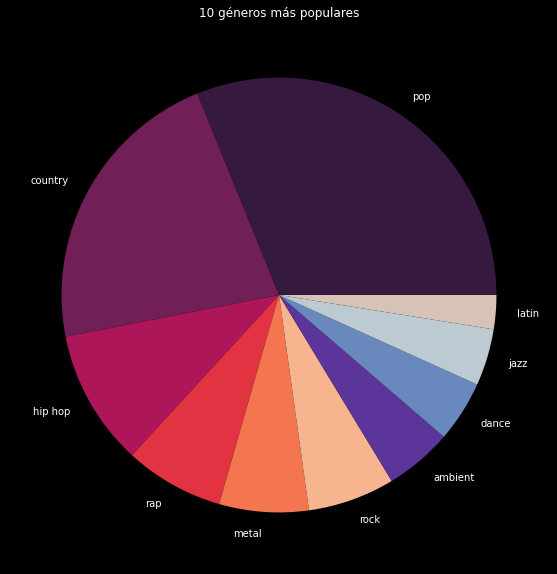

In [192]:
fig = plt.figure(figsize = (10, 10))
ax = fig.subplots()
data.genres.value_counts()[:10].plot(ax=ax, kind = "pie", colors=pal)
ax.set_ylabel("")
ax.set_title('10 géneros más populares')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.show()

Esto intuitivamente se ve mucho mejor.

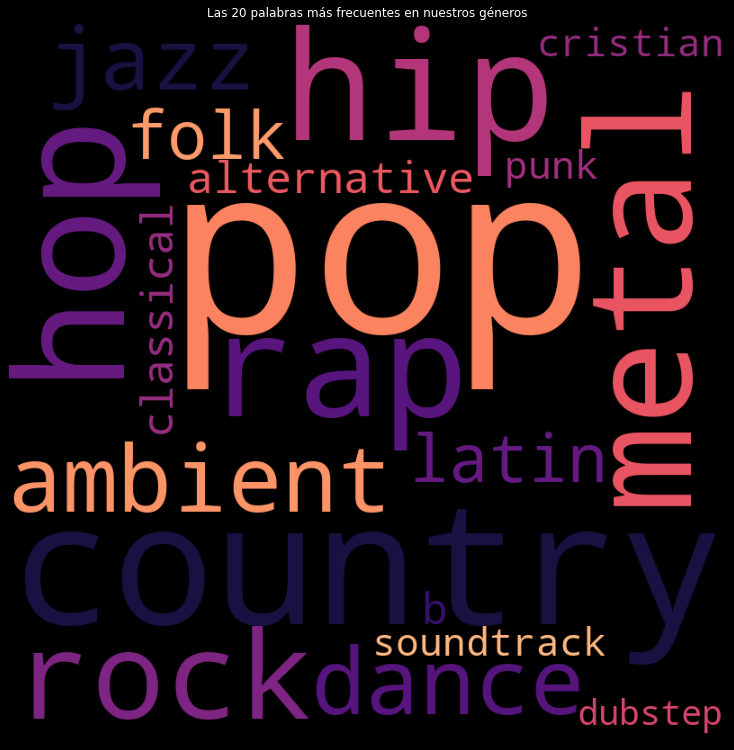

In [193]:
max_words = 20
wordcloud = WordCloud(width = 800, height = 800, max_words = max_words, colormap="magma",
                min_font_size = 10).generate(" ".join(data.genres.value_counts().index.tolist()))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"Las {max_words} palabras más frecuentes en nuestros géneros")
plt.show()

Esto se ve bastante más manejable, vamos a convertirlas en dummies.

In [194]:
genre_dummies = pd.get_dummies(data.genres, drop_first=True)
genre_dummies.head()

,ambient,classical,country,cristian,dance,dubstep,folk,hip hop,jazz,latin,metal,pop,punk,r&b,rap,rock,soundtrack
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [195]:
data_dummies = pd.concat([data, genre_dummies], axis = 1)

In [196]:
data = data_dummies.drop(['genres'], axis=1)

Ahora vamos con la exploración de las continuas:

In [197]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,hip hop,jazz,latin,metal,pop,punk,r&b,rap,rock,soundtrack
count,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000,...,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000,3122.000000
mean,0.573265,0.642955,5.217168,-7.580561,0.687060,0.085464,0.246863,0.112346,0.193884,0.461867,...,0.089686,0.037476,0.022422,0.058937,0.276105,0.009609,0.015375,0.065343,0.057335,0.015375
std,0.175966,0.239822,3.584596,5.193746,0.463765,0.089113,0.308005,0.271867,0.168382,0.243664,...,0.285777,0.189955,0.148074,0.235544,0.447141,0.097570,0.123058,0.247169,0.232519,0.123058
min,0.062500,0.000251,0.000000,-39.286000,0.000000,0.022500,0.000001,0.000000,0.019900,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.473000,0.505250,2.000000,-8.388000,0.000000,0.035400,0.018000,0.000000,0.096800,0.260250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.588000,0.691000,5.000000,-6.021500,1.000000,0.048400,0.096200,0.000004,0.122000,0.458000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.695000,0.828000,8.000000,-4.608750,1.000000,0.090000,0.375750,0.003132,0.235750,0.647750,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.980000,0.998000,11.000000,-0.716000,1.000000,0.733000,0.996000,0.983000,0.980000,0.976000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Vamos a chequear datos faltantes:

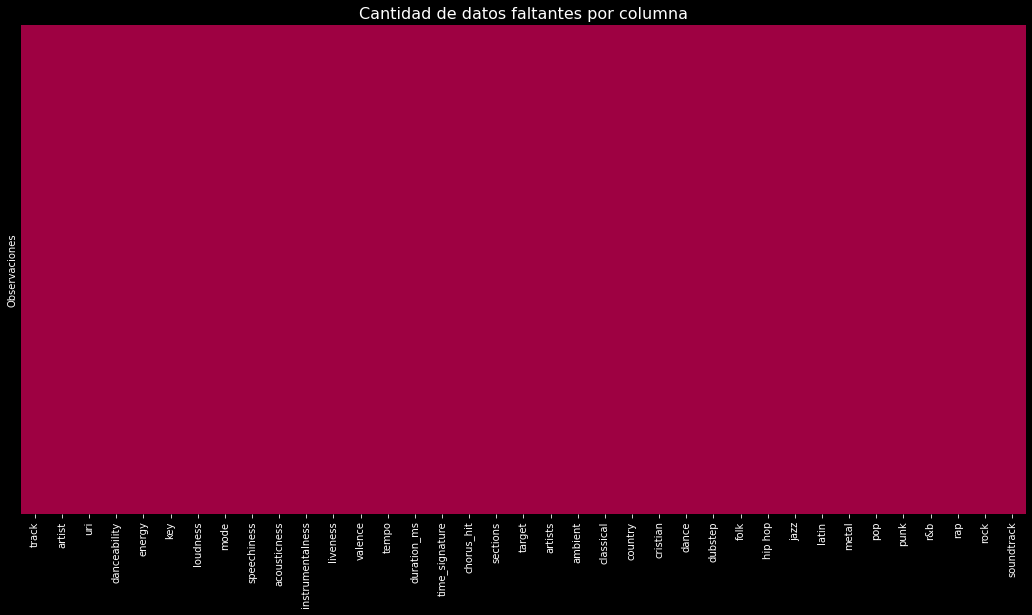

In [198]:
fig, ax = plt.subplots(figsize=(18,9))
sns.heatmap(data.isnull(), cbar=False, cmap='Spectral');
ax.set_title('Cantidad de datos faltantes por columna', fontdict={'fontsize': 16});
ax.set_ylabel('Observaciones');
ax.set_xlabel('');
ax.tick_params(labelleft=False, left=False);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

No tenemos NA's, vamos a ver cómo se distribuyen las variables numéricas y cómo se relacionan entre sí.

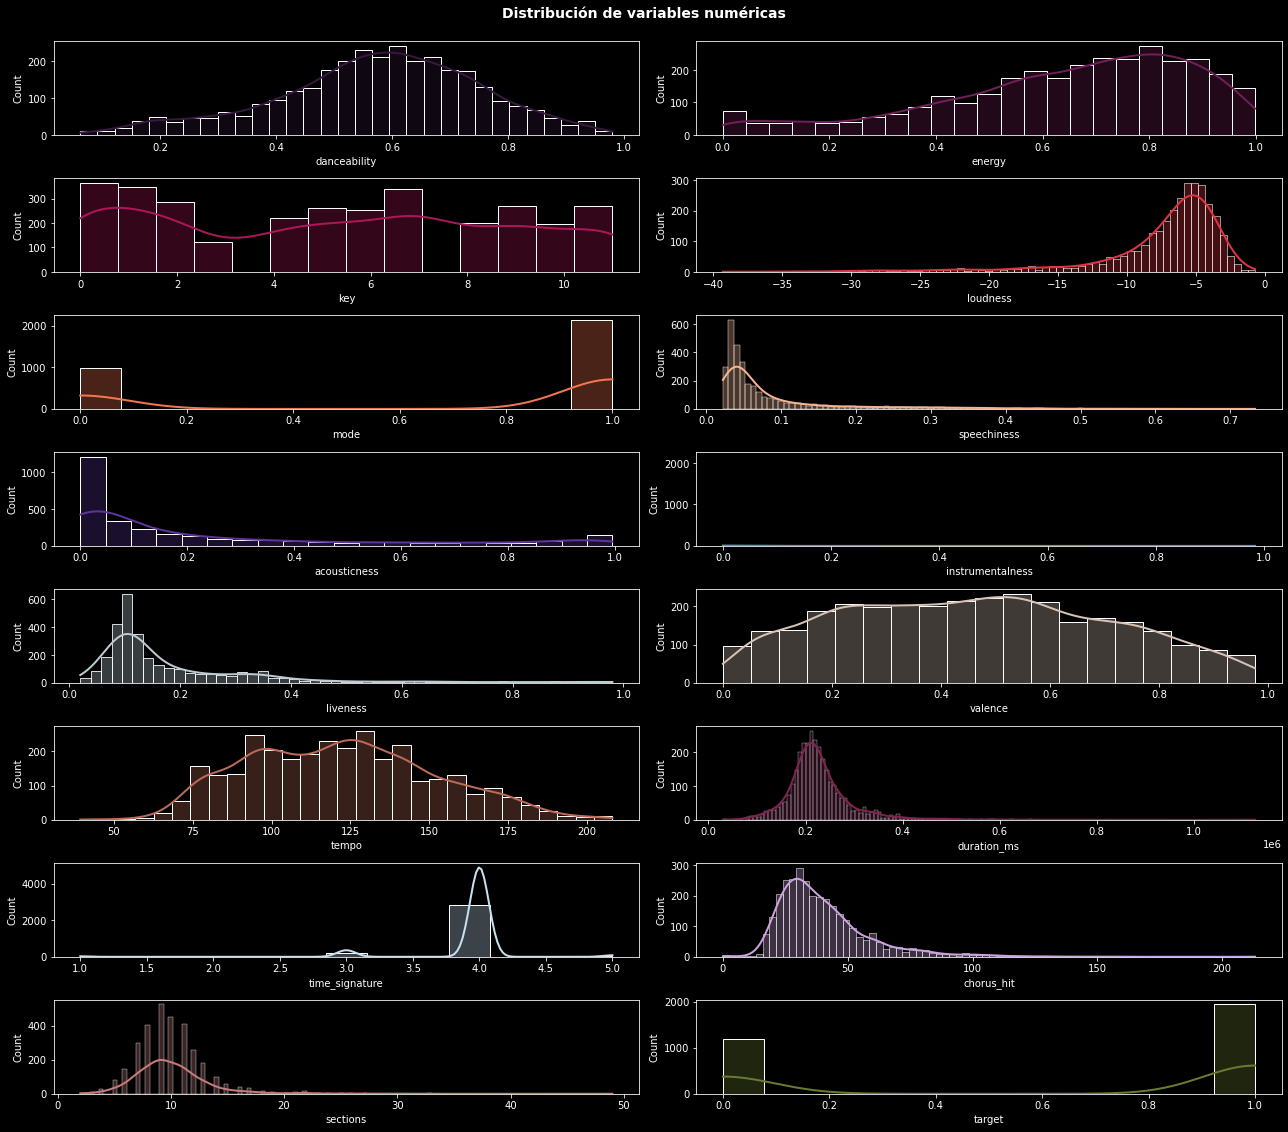

In [199]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(18, 16))
axes = axes.flat
columnas_numeric = data.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = data,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = pal[i],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )

    
fig.tight_layout()
plt.subplots_adjust(top = 0.95)
fig.suptitle('Distribución de variables numéricas', fontsize = 14, fontweight = "bold");

Las distribuciones se ven bien, es coherente que speachiness este concentrada hacia valores bajos, indicando que la mayoría de nuestras observaciones no se constituyen completamente de palabra hablada y que loudness está entre 0 y -10.

Vamos a ver las correlaciones entre nuestras variables.

In [200]:
def matrix_corr(corr_mat):
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = data.select_dtypes(include=['float64', 'int']).corr(method='pearson')
matrix_corr(corr_matrix).head(5)

,variable_1,variable_2,r,abs_r
19,energy,loudness,0.796199,0.796199
49,loudness,energy,0.796199,0.796199
190,duration_ms,sections,0.785787,0.785787
235,sections,duration_ms,0.785787,0.785787
22,energy,acousticness,-0.760664,0.760664


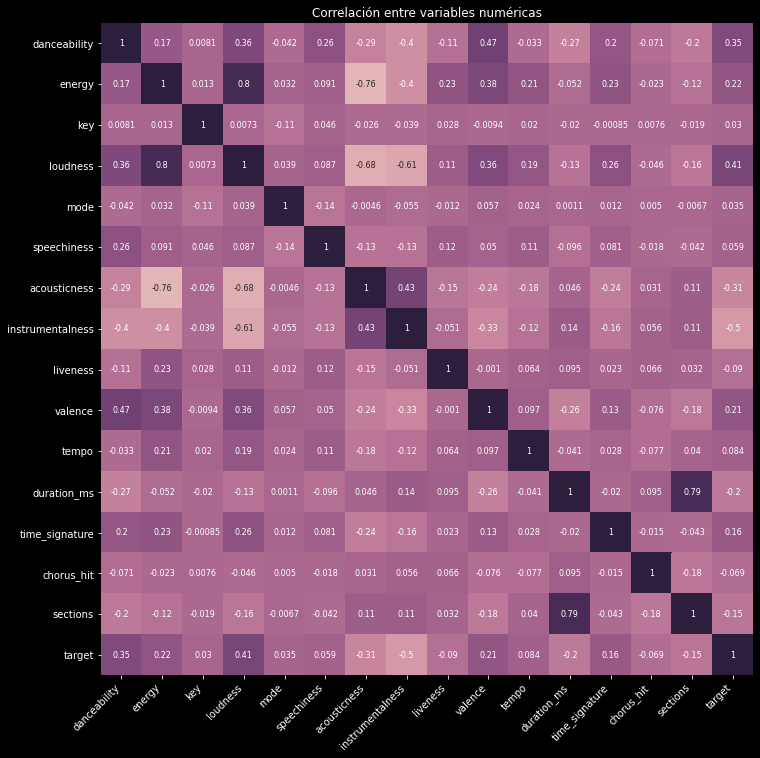

In [201]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.cubehelix_palette(as_cmap=True),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.set_title("Correlación entre variables numéricas")
ax.tick_params(labelsize = 10)

De nuevo, dado cómo están construídas algunas de nuestras features, las correlaciones son esperables. Por ejemplo entre valence y danceability o loudness y energy. Otras son bastante flojas.

Vamos a ver el balance de nuestro target y ya podemos empezar a fitear algún modelo.

In [202]:
data.target.value_counts()

1.0    1938
0.0    1184
Name: target, dtype: int64

Está ligeramente desbalanceado; separamos nuestros features y target. 

In [203]:
X = data.drop(['target', 'artist', 'artists', 'uri', 'track'], axis=1)
y = data.target

Armamos sets de entrenamiento y testeo estratificando por nuestra variable target.

In [204]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y,
                                                stratify = y,
                                                train_size=0.8,
                                                random_state=1234)

## Bayesline

Para tener un baseline, vamos a usar un Naive Bayes.

In [205]:
gnb_model = GaussianNB()
fit = gnb_model.fit(Xtrain, ytrain)

In [206]:
ypred = gnb_model.predict(Xtest)

In [207]:
accuracy_score(ytest, ypred)

0.7552

El accuracy del primer modelo no está nada mal, vamos a ver la matriz de confusión:

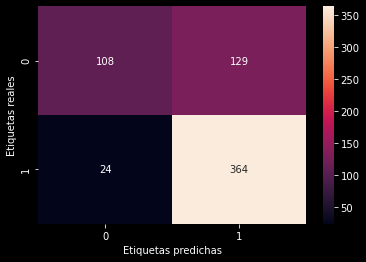

In [208]:
sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='.0f')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [209]:
tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
print(f'Es decir que tenemos: \n{tn} negativos verdaderos')
print(f'{fn} negativos falsos')
print(f'{tp} positivos verdaderos')
print(f'{fp} positivos falsos')

Es decir que tenemos: 
108 negativos verdaderos
24 negativos falsos
364 positivos verdaderos
129 positivos falsos


Este primer modelo ya se ve bastante bien, pero tenemos un problema con los falsos positivos y esto nos molesta particularmente porque identificar un tema como un hit podría hacer que la compañía realice una inversión grande de dinero en un artista y ésta tasa de error no nos deja del todo tranquilos.

Chequeamos la precisión, el recal y el f1:

In [210]:
print(f'La capacidad de nuestro modelo para no decir que un tema es un hit cuando no lo es es: \n{precision_score(ytest, ypred)}')
print(f'La capacidad de nuestro modelo para identificar todos los temas que son hits es: \n{recall_score(ytest, ypred)}')
print(f'La media armónica de las dos medidas anteriores es \n{f1_score(ytest, ypred)}')

La capacidad de nuestro modelo para no decir que un tema es un hit cuando no lo es es: 
0.7383367139959433
La capacidad de nuestro modelo para identificar todos los temas que son hits es: 
0.9381443298969072
La media armónica de las dos medidas anteriores es 
0.8263337116912599


Acá vemos con claridad cómo nuestro modelo tiene un sesgo positivo en el que predice que casi todo lo que encuentra es un hit y eso explica porqué tenemos tantos falsos positivos.

Vamos a mirar la curva roc_auc

In [211]:
def plot_roc_curve(ytest, ypred):
    
    auc = roc_auc_score(ytest, ypred)
    false_positive_rate, true_positive_rate, thresolds = roc_curve(ytest, ypred)

    plt.figure(figsize=(12, 6))
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'purple')
    plt.fill_between(false_positive_rate, 
                     true_positive_rate, 
                     facecolor=sns.color_palette('magma')[1], 
                     alpha=0.2)
    plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='white')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

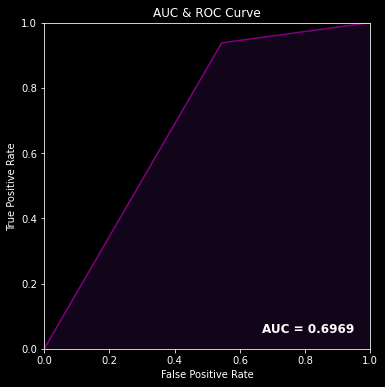

In [212]:
plot_roc_curve(ytest, ypred)

Como primer modelo es bastante aceptable, aunque el área bajo la curva no es tanto mejor que el azar. 
Vamos a probar ahora con KNN a ver si podemos mejorarlo.

## k-NN

Para calcular las distancias necesitamos escalar nuestros features de entrenamiento y le enseñamos eso a los features de testeo.

In [213]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)
pd.DataFrame(Xtrain).describe().round()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,2497.0,2497.0,2497.0,2497.0,2497.0,2497.0,2497.0,2497.0,2497.0,2497.0,...,2497.0,2497.0,2497.0,2497.0,2497.0,2497.0,2497.0,2497.0,2497.0,2497.0
mean,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-3.0,-3.0,-1.0,-6.0,-2.0,-1.0,-1.0,-0.0,-1.0,-2.0,...,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0
25%,-1.0,-1.0,-1.0,-0.0,-2.0,-1.0,-1.0,-0.0,-1.0,-1.0,...,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0
50%,0.0,0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0
75%,1.0,1.0,1.0,1.0,1.0,0.0,0.0,-0.0,0.0,1.0,...,-0.0,-0.0,-0.0,-0.0,2.0,-0.0,-0.0,-0.0,-0.0,-0.0
max,2.0,1.0,2.0,1.0,1.0,7.0,2.0,3.0,5.0,2.0,...,3.0,5.0,7.0,4.0,2.0,10.0,8.0,4.0,4.0,8.0


Vamos a validar los hiperparametros de nuestro k-nn, para ello usamos una grilla para chequear hiperparámetros exhaustivamente y además, como nuestro target estaba un tanto desbalanceado, usamos un esquema de validación cruzada estratificado:

In [214]:
parameters = {'n_neighbors': np.arange(1, 22, 1), 'weights':('uniform', 'distance'), 'metric':('euclidean', 'manhattan', 'chebyshev', 'minkowski')}
scores = {'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score), 'accuracy_score': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score)}
knn = KNeighborsClassifier()
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
knnCV = GridSearchCV(knn, parameters, cv=folds, n_jobs=-1, scoring=scores, refit='roc_auc')

In [215]:
knnCV.fit(Xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ('euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'),
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21]),
                         'weights': ('uniform', 'distance')},
             refit='roc_auc',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [216]:
knnCV.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=8, weights='distance')

In [217]:
ypred = knnCV.predict(Xtest)

In [218]:
accuracy_score(ytest, ypred)

0.8944

Acá el accuracy se disparó bastante, vamos a chequear la matriz de confusión.

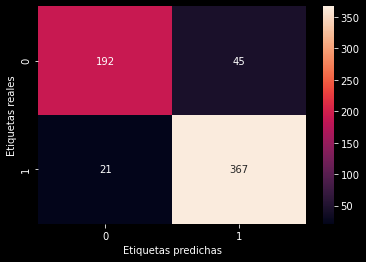

In [219]:
sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='.0f')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [220]:
tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
print(f'Es decir que tenemos: \n{tn} negativos verdaderos')
print(f'{fn} negativos falsos')
print(f'{tp} positivos verdaderos')
print(f'{fp} positivos falsos')

Es decir que tenemos: 
192 negativos verdaderos
21 negativos falsos
367 positivos verdaderos
45 positivos falsos


Miremos las probabilidades de clasificar correcta o incorrectamente los temas como hits.

In [221]:
cm = confusion_matrix(ytest, ypred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

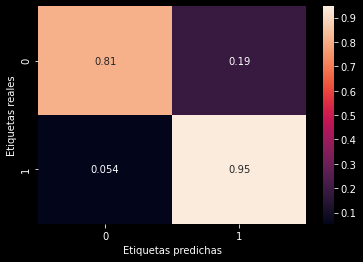

In [222]:
sns.heatmap(cm_normalized, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

Las predicciones de nuestro modelo parecen ser bastante buenas, mejorar un poco el problema de los falsos positivos nos vendria bien. 

Vamos a chequear la precisión.

In [223]:
print(f'La capacidad de nuestro modelo para no decir que un tema es un hit cuando no lo es es: \n{precision_score(ytest, ypred)}')
print(f'La capacidad de nuestro modelo para identificar todos los temas que son hits es: \n{recall_score(ytest, ypred)}')
print(f'La media armónica de las dos medidas anteriores es \n{f1_score(ytest, ypred)}')

La capacidad de nuestro modelo para no decir que un tema es un hit cuando no lo es es: 
0.8907766990291263
La capacidad de nuestro modelo para identificar todos los temas que son hits es: 
0.9458762886597938
La media armónica de las dos medidas anteriores es 
0.9175


In [224]:
print(classification_report(ytest, ypred, target_names=['flop', 'hit']))

              precision    recall  f1-score   support

        flop       0.90      0.81      0.85       237
         hit       0.89      0.95      0.92       388

    accuracy                           0.89       625
   macro avg       0.90      0.88      0.89       625
weighted avg       0.89      0.89      0.89       625



In [225]:
roc_auc_score(ytest, ypred)

0.8780014354691374

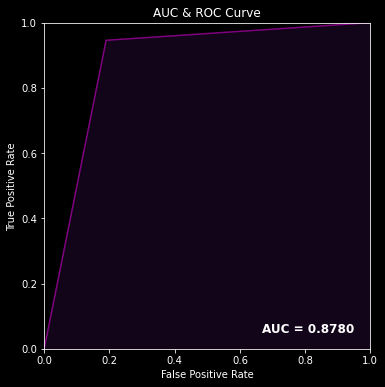

In [226]:
plot_roc_curve(ytest, ypred)

Vamos a ver los thresholds y si podemos modificarlos para mejorar un poco la precisión.

In [227]:
ypred_proba = knnCV.predict_proba(Xtest)

In [228]:
def pres_rec_thresh(ytest, ypred_proba):
    precision, recall, thresholds = precision_recall_curve(ytest, ypred_proba[:, 1]) 
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(12, 6))
    plt.title("Precision/Recall vs. Threshold")
    plt.plot(thresholds, precision[: -1], pal[1], label="Precision")
    plt.plot(thresholds, recall[: -1], pal[2], label="Recall")
    plt.ylabel("Precision/Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0,1]);

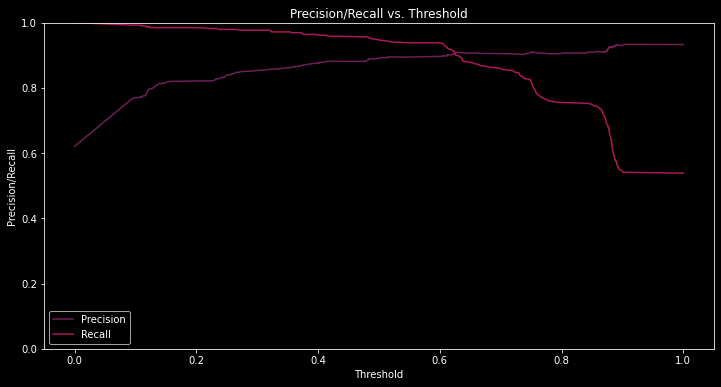

In [229]:
pres_rec_thresh(ytest, ypred_proba)

In [230]:
ypred_thresh = (knnCV.predict_proba(Xtest)[:,1]>=0.63).astype(int)

In [231]:
roc_auc_score(ytest, ypred_thresh)

0.8746139458001653

In [233]:
print(classification_report(ytest, ypred_thresh, target_names=['flop', 'hit']))

              precision    recall  f1-score   support

        flop       0.83      0.85      0.84       237
         hit       0.91      0.90      0.90       388

    accuracy                           0.88       625
   macro avg       0.87      0.87      0.87       625
weighted avg       0.88      0.88      0.88       625



De este modo podemos mejorar un poco la precisión sin sacrificar tanto recall.

## Regresión logística

Vamos a probar con una regresión logística a ver si podemos mejorar aún más.

In [234]:
parameters = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 50)}
scores = {'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score), 'accuracy_score': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score)}
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
logit = LogisticRegression(max_iter=1000)
logitCV = GridSearchCV(logit, parameters, cv=folds, n_jobs=-1, scoring=scores, refit='roc_auc')

In [235]:
logitCV.fit(Xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1....
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             refit='roc_auc',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [236]:
logitCV.best_estimator_

LogisticRegression(C=1.7575106248547894, max_iter=1000)

In [237]:
ypred = logitCV.predict(Xtest)

In [238]:
accuracy_score(ytest, ypred)

0.888

El accuracy baja un toque, pero vamos a chequear las matrices y el roc_auc_score.

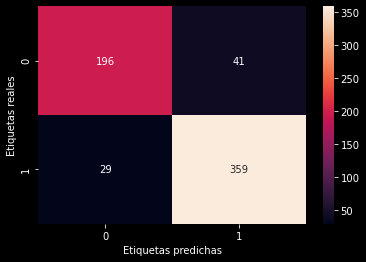

In [239]:
sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='.0f')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [240]:
tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
print(f'Es decir que tenemos: \n{tn} negativos verdaderos')
print(f'{fn} negativos falsos')
print(f'{tp} positivos verdaderos')
print(f'{fp} positivos falsos')

Es decir que tenemos: 
196 negativos verdaderos
29 negativos falsos
359 positivos verdaderos
41 positivos falsos


In [241]:
cm = confusion_matrix(ytest, ypred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

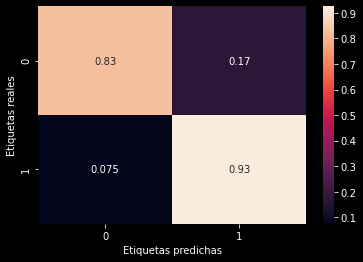

In [242]:
sns.heatmap(cm_normalized, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [243]:
print(f'La capacidad de nuestro modelo para no decir que un tema es un hit cuando no es un hit es: \n{precision_score(ytest, ypred)}')
print(f'La capacidad de nuestro modelo para identificar todos los temas que son hits es: \n{recall_score(ytest, ypred)}')
print(f'La media armónica de las dos medidas anteriores es \n{f1_score(ytest, ypred)}')

La capacidad de nuestro modelo para no decir que un tema es un hit cuando no es un hit es: 
0.8975
La capacidad de nuestro modelo para identificar todos los temas que son hits es: 
0.9252577319587629
La media armónica de las dos medidas anteriores es 
0.9111675126903553


In [244]:
print(classification_report(ytest, ypred, target_names=['flop', 'hit']))

              precision    recall  f1-score   support

        flop       0.87      0.83      0.85       237
         hit       0.90      0.93      0.91       388

    accuracy                           0.89       625
   macro avg       0.88      0.88      0.88       625
weighted avg       0.89      0.89      0.89       625



In [245]:
roc_auc_score(ytest, ypred)

0.8761309756840229

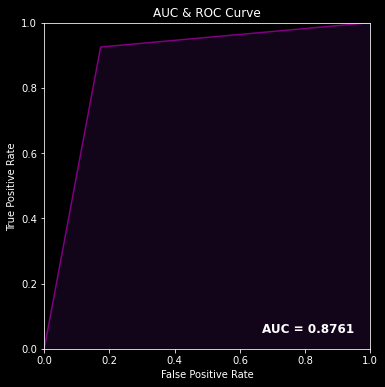

In [246]:
plot_roc_curve(ytest, ypred)

Si bien el accuracy es un poco más bajo pero parece inherentemente mejor balanceado, tenemos buena precisión y buen recall aún con el umbral por default, pero nos gustaría subir un poquito más la precisión.

Vamos a plotear la presición y el recall contra distintos thresholds de nuevo a ver si podemos elegir uno que funcione un poco mejor.

In [247]:
ypred_proba = logitCV.predict_proba(Xtest)

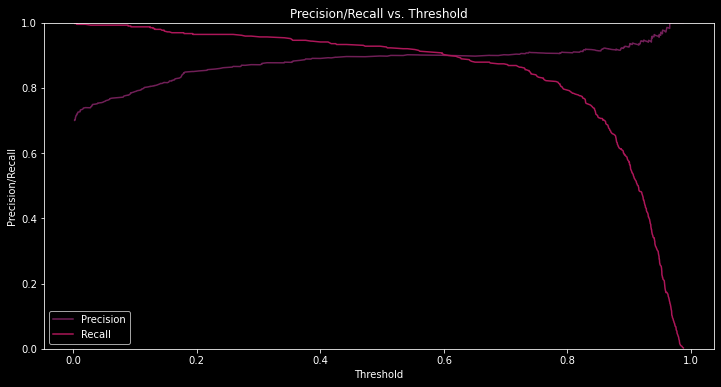

In [248]:
pres_rec_thresh(ytest, ypred_proba)

In [249]:
ypred_thresh = (logitCV.predict_proba(Xtest)[:,1]>=0.6).astype(int)

In [250]:
roc_auc_score(ytest, ypred_thresh)

0.8687524468223933

In [251]:
print(classification_report(ytest, ypred_thresh, target_names=['flop', 'hit']))

              precision    recall  f1-score   support

        flop       0.84      0.84      0.84       237
         hit       0.90      0.90      0.90       388

    accuracy                           0.88       625
   macro avg       0.87      0.87      0.87       625
weighted avg       0.88      0.88      0.88       625



Bueno, parecería que el mejor modelo que podemos encontrar por ahora es el knn, que tiene buena performance en general y si tuneamos un poco el umbral de decisión podemos llegar a un buen balance de precisión y recall.

Sin embargo, nos gustaría ir un poco más profundo ya que a la hora de incorporar nuevos artistas, a la empresa le gustaría saber en qué dirección buscar, una vez que ingresaron los temas en el modelo obtienen una buena predicción pero antes hay que saber dónde buscar los temas: 

¿Todos los géneros tienen la misma importancia?

¿Es más importante que un tema sea bailable o que tenga alta energía?

Para empezar a contestar este tipo de preguntas podemos usar una técnica que se llama permutation importance, en la que desordenamos los valores de una variable por vez y vemos cómo esto afecta el fit de nuestro modelo. La medida en la que nuestro modelo se ve perturbado por las modificaciones en una feature nos provee una métrica del grado de importancia que esa variable tiene en nuestro modelo.

Valores altos indican que esa variable tiene un impacto muy alto sobre nuestro accuracy visto que, al mezclar el orden de sus valores, éste baja considerablemente.

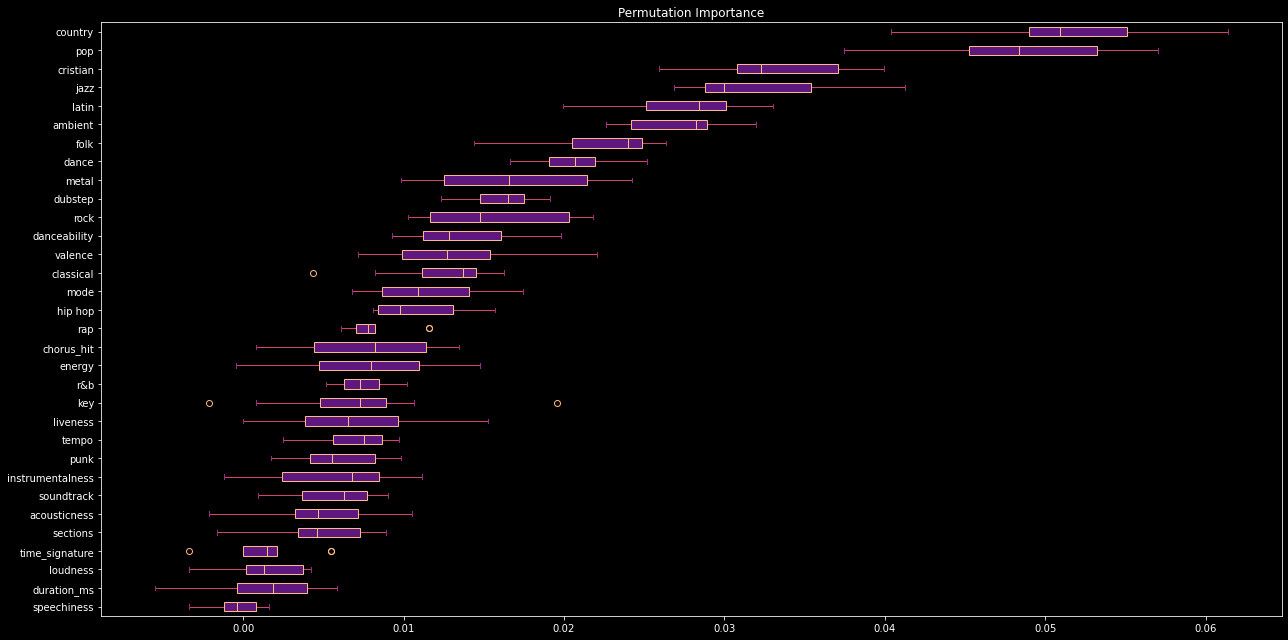

In [252]:
result = permutation_importance(knnCV, Xtest, ytest, n_repeats=10,
                               random_state=0)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(18, 9))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, 
            labels=np.array(X.columns)[sorted_idx],
            patch_artist=True,
            boxprops=dict(facecolor=sns.color_palette('magma')[1], color=sns.color_palette('magma')[5]),
            capprops=dict(color=sns.color_palette('magma')[2]),
            whiskerprops=dict(color=sns.color_palette('magma')[3]),
            flierprops=dict(color=sns.color_palette('magma')[4], markeredgecolor=sns.color_palette('magma')[5]),
            medianprops=dict(color=sns.color_palette('magma')[5]))
plt.title("Permutation Importance")
fig.tight_layout()
plt.show()

En el gráfico podemos ver cómo las variables que más importancia tienen para nuestro modelo son los géneros, específicamente los géneros que están más representados en nuestros datos, y después el grado de bailabilidad de la música y su valencia.

Esto es importante porque permite direccionar la búsqueda de nuevos artistas de géneros específicos como country o pop que tengan alto grado de bailabilidad y valencia positiva.